In [1]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler, DataLoader
from torchvision.utils import draw_bounding_boxes
import torchvision
import torch.nn as nn
from math import ceil
import copy
import os
import torchvision.transforms as transforms
import json
from utils import functions

C:\Users\Peter\anaconda3\envs\promracing1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### αρχικά πλοτάρουμε μια τυχαία εικόνα από το Dataset της AMZ ώστε να δούμε τη μορφή που έχουν οι εικόνες μας
παρατηρούμε ότι όλες οι εικόνες έχουν μέγεθος (1480, 1880) (τουλάχιστον σε αυτό το dataset)

torch.Size([3, 1480, 1880])


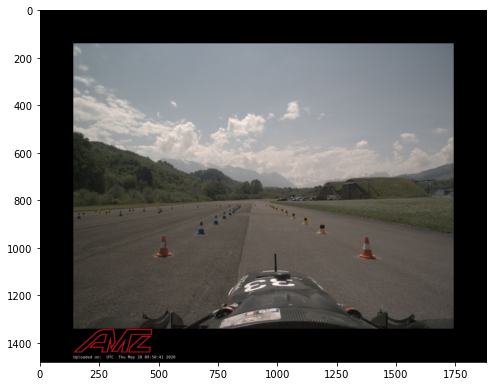

In [3]:
with open('amz-20220426T145517Z-001/amz/ann/amz_00000.jpg.json') as f:
    data = json.load(f)

image = torchvision.io.read_image('amz-20220426T145517Z-001/amz/img/amz_00000.jpg')
boxes = torch.zeros((len(data['objects']), 4))


print(image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(image, (1, 2, 0)))


Στη συνέχεια θα πλοτάρουμε την ίδια εικόνα μαζί με τα bounding boxes ώστε να σιγουρευτούμε ότι φορτώνουμε σωστά τις συντεταγμένες των bounding boxes

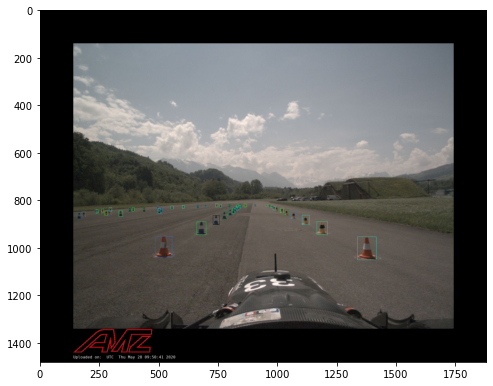

In [4]:
scale = np.array([1, 1])
for i, obj in enumerate(data['objects']):
    #boxes.append(obj['points']['exterior'])
    boxes[i, :] = torch.Tensor.int(torch.from_numpy(np.multiply(np.asarray(obj['points']['exterior']), scale).flatten()))

x = draw_bounding_boxes(image, boxes)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(x, (1, 2, 0)))

παρατηρούμε ότι πράγματι αυτός είναι ο σωστός τρόπος να φορτώσουμε και να πλοτάρουμε τα bounding boxes. Παρόλα αυτά έχουμε 2 σημαντικά προβλήματα 
* το περίγραμμα των εικόνων περίεχει ένα μάυρο πλαίσιο με το λογότυπο της AMZ, κάτι που προφανώς πρέπει να αφαιρέσουμε για να εκπαιδεύσουμε σωστά το YOLO
* πρέπει να κάνουμε resize στις εικόνες μας (εξού και ο παράγοντας scale παραπάνω). 
Κάνοντας τα παραπάνω προκύπτει το εξής πρόβλημα: οι συντεταγμένες των bounding boxes στο dataset προφανώς θα αλλάξουν, για κάθε έναν από τους 2 παραπάνω <μετασχηματισμούς>. Άρα θα πρέπει να φτοιάξουμε μια συνάρτηση η οποία θα δέχεται ως είσοδο τις 2 δυάδες που χαρακτηρίζουν ένα bounding box και επιστρέφει τις σωστές συντεταγμένες μετά από τους 2 παραπάνω μετασχηματισμούς. 

In [5]:

print(len(data['objects'])) # this particular image contains 50 cones and that's why it's length is 50
print(data['objects'][2])
print(data['objects'][2]['points'])
print(data['objects'][2]['points']['exterior'])



50
{'id': 889945761, 'classId': 9993511, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'fsocov2', 'createdAt': '2020-06-04T10:03:32.323Z', 'updatedAt': '2020-06-04T10:03:32.323Z', 'tags': [], 'classTitle': 'blue_cone', 'points': {'exterior': [[659, 890], [698, 944]], 'interior': []}}
{'exterior': [[659, 890], [698, 944]], 'interior': []}
[[659, 890], [698, 944]]


βλέπουμε ότι για κάθε bounding box τα σημεία είναι σε μορφή embedded λίστας σε μορφή $[(x_{min},y_{min}) (x_{max},y_{max})] $ ;Άρα θα πρέπει να φτιάξουμε μια συνάρτηση η οποία θα δέχεται μια λίστα της παραπάνω μορφής και θα επιστρέφει ένα numpy array με τις παραπάνω συντεταγμένες ως γραμμές (πιστεύω ότι θα χρειαστεί η παραπάνω μορφή για τη συνέχεια)

* Αρχικά θα δοκιμάσω να πλοτάρω την εικόνα που προκύπτει μετά από central crop αλλά και τα bounding boxes που προκύπτουν μετά από αυτόν τον μετασχηματισμό μόνο. Η ιδέα είναι ότι αν αρχικά οι συντεταγμένες είναι $ (χ_{initial},y_{initial}) $ τότε αν κάνουμε crop $(a,b)$ pixel οι νέες συντεταγμένες θα είναι $ (χ_{final},y_{final}) = (x_{initial}, y_{initial}) - (\frac{a}{2},\frac{b}{2}) $

[140. 140.]


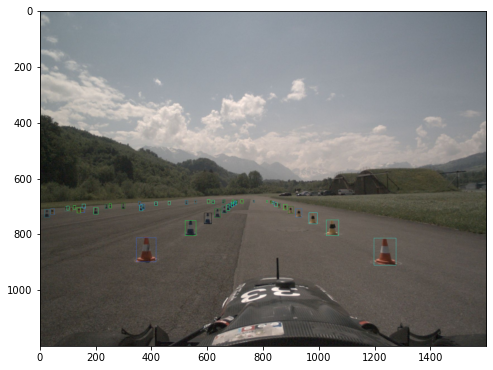

In [6]:
class Transform(object):
    def __init__(self):
        self.t = transforms.Compose([
            transforms.CenterCrop((1200, 1600))
        ])

    def __call__(self, s):
        return self.t(s)

transform = Transform()
croped_image = transform(image)
croped_size = (image.shape[1:3] - np.array([1200, 1600]))/2
print(croped_size)
boxes = torch.zeros((len(data['objects']), 4))
for i, obj in enumerate(data['objects']):
    #boxes.append(obj['points']['exterior'])
    boxes[i, :] = torch.Tensor.int(torch.from_numpy(np.asarray(obj['points']['exterior'] - croped_size).flatten()))

x = draw_bounding_boxes(croped_image, boxes)

plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(x, (1, 2, 0)))

Στη συνέχεια στόχος μας είναι αφού κάνουμε ένα scaling στην εικόνα κατά τον παράγοντα $ (k_x, k_y) $ να βρούμε τις νέες συντεταγμένες των bounding boxes. Αν κάνουμε scaling στην εικόνα κατά το παράγοντα $ (k_x,k_y) $ τότε οι νέες συντεταγμένες θα είναι $ (x_{init},y_{init}) \rightarrow (k_x \cdot x_{init},k_y \cdot y_{init}) $. 

amz-20220426T145517Z-001\amz
name is ann
name is img


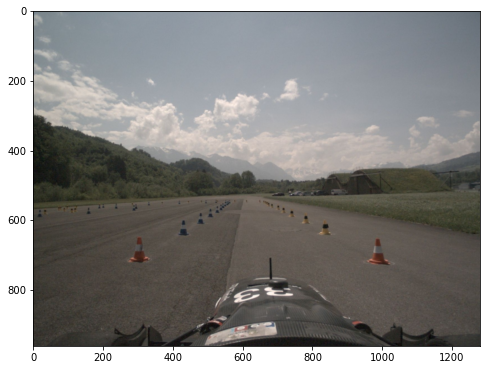

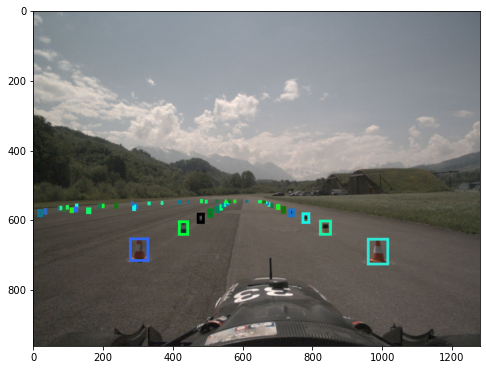

In [4]:
class Transform(object):
    def __init__(self, img_shape=None):
        self.shape = img_shape
        self.t = transforms.Compose([
            transforms.CenterCrop((self.shape[0] - 280, self.shape[1] - 280)),
            transforms.Resize((960, 1280))
        ])

    def __call__(self, s):
        return self.t(s)

class YOLOdataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.final_size = np.array([960, 1280])
        self.AMZ_crop = np.array([280, 280])
        self.images, self.image_boxes = self.get_images_boxes_labels()

    def get_images_boxes_labels(self):
        images = []
        boxes = []
        labels = []
        for j in os.listdir(path=self.path):
            new_path = os.path.join(self.path, j)
            print(new_path)
            for name in os.listdir(new_path):
                new_path1 = os.path.join(new_path, name)
                print('name is', name)
                if name == 'img':
                    i = 0
                    for img_name in os.listdir(path=new_path1):
                        img_path = os.path.join(new_path1, img_name)
                        image = torchvision.io.read_image(img_path)
                        image_transform = Transform(img_shape=image.shape[1:3])
                        image = image_transform(image)
                        images.append(image)
                        i += 1
                        if i == 100: break
                        
                elif name == 'ann':
                    for json_name in os.listdir(new_path1):
                        json_path = os.path.join(new_path1, json_name)
                        with open(json_path) as f:
                            data = json.load(f)
                        images_boxes = []
                        image_dimensions = np.asarray(list(data['size'].values()))
                        for obj in data['objects']:
                            box_coordinates = np.asarray(obj['points']['exterior'])  # the coordinates are in the form of embedded list [[x_min, y_min], [x_max, y_max]]
                            new_box_coordinates = functions.new_boxes_coordinates(image_size=image_dimensions, final_size=self.final_size, box_coordinates=box_coordinates, crop=self.AMZ_crop)
                            images_boxes.append(new_box_coordinates)
                        boxes.append(images_boxes)

        return images, boxes


t = YOLOdataset(path='amz-20220426T145517Z-001')



image = t.images[0]
boxes = t.image_boxes[0]
boxes = torch.from_numpy(np.asarray(boxes)).view(50, 4)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()
image = draw_bounding_boxes(image, boxes, width=8)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()


30


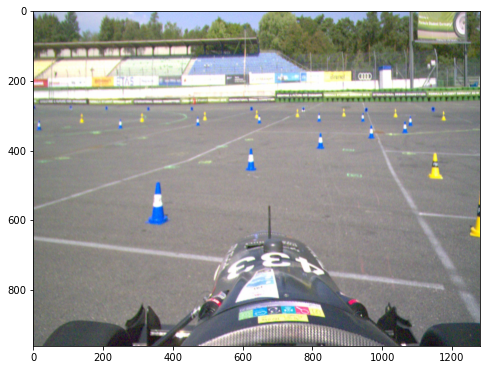

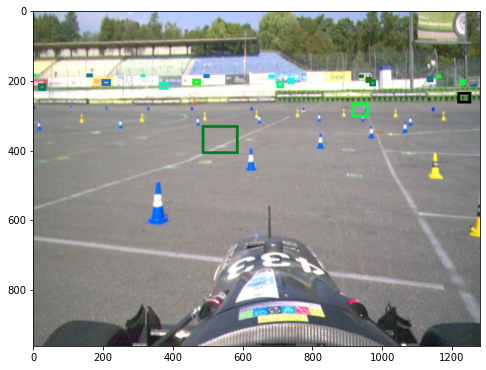

In [9]:
image = t.images[50]
boxes = t.image_boxes[50]
print(len(boxes))
boxes = torch.from_numpy(np.asarray(boxes)).view(30, 4)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()
image = draw_bounding_boxes(image, boxes, width=8)
plt.figure(figsize=(8, 8))
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()
